# Model Training Plan

In [198]:
import logging
from completejourney_py import get_data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from syncomp.utils.data_util import CompleteJourneyDataset
logger = logging.getLogger()
logger.setLevel(logging.INFO)

%reload_ext autoreload
%autoreload 2

## Raw Data Analysis

In [2]:
complete_dataset = get_data()
complete_dataset["transactions"].dtypes

household_id                      int64
store_id                          int64
basket_id                         int64
product_id                        int64
quantity                          int64
sales_value                     float64
retail_disc                     float64
coupon_disc                     float64
coupon_match_disc               float64
week                              int64
transaction_timestamp    datetime64[ns]
dtype: object

In [3]:
complete_dataset["transactions"][["household_id", "product_id","store_id", "week"]].nunique()

household_id     2469
product_id      68509
store_id          457
week               53
dtype: int64

In [4]:
complete_dataset["products"].dtypes

product_id           int64
manufacturer_id      int64
department          object
brand               object
product_category    object
product_type        object
package_size        object
dtype: object

In [5]:
complete_dataset["demographics"].dtypes

household_id       int64
age               object
income            object
home_ownership    object
marital_status    object
household_size    object
household_comp    object
kids_count        object
dtype: object

## Preprocessing

In [178]:
cd = CompleteJourneyDataset(threshold_to_remove_products=20, threshold_to_combine_products=500)
data = cd.run_preprocess()
train_data = cd.combine_product_with_few_transactions(data)

INFO:root:Filter out transactions with non-positive quantity sold or money spent. Number of transactions are decreased to 1458032.
INFO:root:Use the same label for products with the same hierarchy information. Number of products are decreased to 32333.
INFO:root:Use the same label for customers with the same hierarchy information. Number of customers are decreased to 432.
INFO:root:Filter out transactions with invalid customer id. Number of transactions are decreased to 713813.
INFO:root:Filter out transactions with extreme large quantity sold. Number of transactions are decreased to 707898.
INFO:root:Remove 16279 products with few transactions. Number of transactions are decreased to 628134.


INFO:root:Combine 5966 products with few transactions to belong to one category.


Numerical columns include information like unit price, base price, source of discounts, quantity purchased and revenue per transactions. Notice that 

$unit\_price = sales\_value / quantity$ \
$base\_price = (sales\_value + retail\_disc + coupon\_match\_disc + coupon\_disc) / quantity$ \
$unit\_price = base\_price * (1 - retail\_discount\_portion - coupon\_match\_discount\_portion - coupon\_discount\_portion)$



To increase the density of effective rows, we do the followings:
- Combine products with the same hierarchy information, and reassign `product_id`.
- Combine customers with the same demographic information, and reassign `household_id`.
- Remove products with less than 20 weekly transactions in the dataset.
- Combine products which the number of transactions is larger than 20 and smaller than 500. Reassign all product hierarchy information to be -1.

After the last step, we have ~72% transactions from infrequent products in the combined category.

In [185]:
train_data.query('product_id == "-1"').shape[0] / train_data.shape[0]

0.7254869183963931

Except for the identifiers for products and customers (`product_id`, `houshold_id`), we examine the number of unique values for the remaining categorical columns by `department`. From the table below, we could fit a synthesier for each department because each segment contains at most 67 unique values in any column.

In [186]:
str_columns = train_data.select_dtypes(include='object').columns.drop(["product_id", "household_id"])
train_data.groupby(["department"])[str_columns].nunique().describe()

,week,manufacturer_id,department,brand,product_category,product_type,package_size,age,income,home_ownership,marital_status,household_size,household_comp,kids_count
count,9.0,9.000000,9.0,9.000000,9.000000,9.000000,9.000000,9.0,9.0,9.0,9.0,9.0,9.0,9.0
mean,53.0,7.111111,1.0,1.444444,8.111111,13.666667,9.222222,6.0,12.0,5.0,3.0,5.0,4.0,4.0
std,0.0,11.698765,0.0,0.527046,12.004629,22.836374,16.029487,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,53.0,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,6.0,12.0,5.0,3.0,5.0,4.0,4.0
25%,53.0,2.000000,1.0,1.000000,2.000000,3.000000,1.000000,6.0,12.0,5.0,3.0,5.0,4.0,4.0
50%,53.0,4.000000,1.0,1.000000,3.000000,4.000000,2.000000,6.0,12.0,5.0,3.0,5.0,4.0,4.0
75%,53.0,5.000000,1.0,2.000000,4.000000,4.000000,4.000000,6.0,12.0,5.0,3.0,5.0,4.0,4.0
max,53.0,38.000000,1.0,2.000000,36.000000,67.000000,48.000000,6.0,12.0,5.0,3.0,5.0,4.0,4.0


In [16]:
train_data.groupby(["department"])["week"].count().describe()

count         9.000000
mean      69792.666667
std      149193.942256
min        1838.000000
25%        2381.000000
50%        4664.000000
75%       43161.000000
max      455703.000000
Name: week, dtype: float64

Checking the sample size of each department, we find the minimum number transactions is 1838. This means that we could partition the training data department-wise and train a model for each department.

## Model & Training strategies

`product_id` is essentially the encoded label for all the other product hierarchy columns, that it does not have a meaningful interpretation. So does `household_id`. Therefore, to train the synthesizer, it would be better to drop these two columns to train the synthesizer.

## Risk & Considerations

Partitioned by department, each string column could have skewed distributions, which may lead to the model not learning the less frequent patterns adequately.

In [208]:
train_data.department.unique()

array(['-1', 'grocery', 'produce', 'deli', 'drug gm', 'meat-pckgd',
       'meat', 'pastry', 'salad bar'], dtype=object)

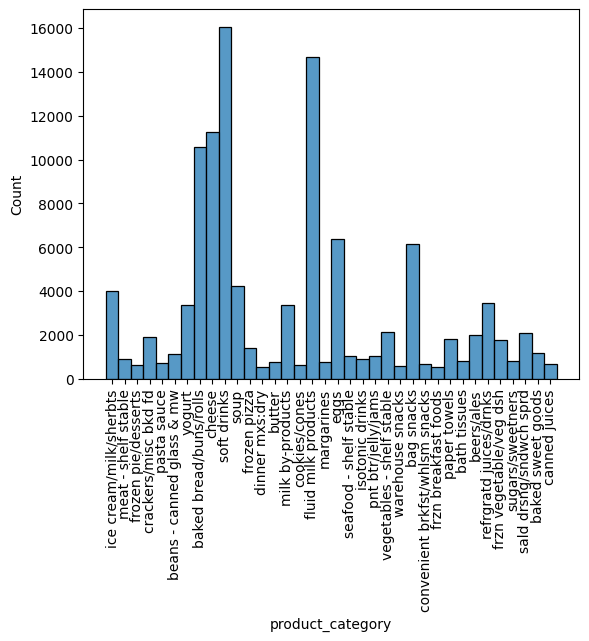

In [213]:
department = 'grocery'
col = 'product_category'
ax = sns.histplot(data=train_data.query(f'department == "{department}"'), x=col)
ax.tick_params(axis="x", rotation=90)